# DQN cartpole

In [78]:
import gym
import numpy as np
import random
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from collections import deque
from tqdm import trange
from IPython.display import clear_output

In [79]:
env = gym.make('CartPole-v1')
env._max_episode_steps=1000 # 기본 CarPole의 최대 maximum step은 500으로 고정 -> 필자는 2000으로 customizing
print(env._max_episode_steps)

1000


In [80]:
s = env.reset()
n_state = s.shape[0]
n_action = env.action_space.n
print('State dimension',n_state)
print('Number of action option',n_action)

State dimension 4
Number of action option 2


In [ ]:
# 알고리즘 메인구조 작성 -> 아직 작동못함!
def DQN_train(#<입력인자들은 추후에 채웁시다>):
    # <초기 변수들 지정>
    # <Capacity에 맞도록 메모리 초기화>
    # <main network, target network 설정 후 동기화>
    for epoch in range(epochs):
        episode_reward = 0
        s = env.reset() 
        while True: # Cart가 쓰러질때까지 계속 반복
            # <action 추출, Epsilon-greedy>
            new_s, r, done, _ = env.step(a)
            # <메모리 push, [s,a,r,new_s,done]>
            # <메모리 샘플링 및 학습-> 일정 batch크기 이상> ! Trick -> 메모리 버퍼가 1000이상일때부터 학습
            # <특정 주기마다 target network <- main network 덧씌우기>
            s = new_s
            episode_reward += r
            if done:
                break
        # <학습과정 출력> - Optional
    return main_model

In [81]:
# 메모리 버퍼를 만듭시다. 메모리마다 [s,a,r,s']의 정보를 업데이트
# 메모리의 최대 용량은 100,000으로 설정 -> 랜덤 샘플링 진행
class memory(object):
    '''
    Replay buffer를 준비합니다.
    특별한 경우를 제외하고는 버퍼의 길이는 50,000으로 초기설정을 놓습니다.
    기능
        1. push: 버퍼의 끝에서부터 원소를 집어넣습니다. 
        2. sample: 샘플링할 크기만큼 버퍼에서 임의의 원소들을 추출합니다.
    '''
    def __init__(self,capacity=50000):
        self.memory = deque([],maxlen=capacity) 
    def push(self,*args):
        '''
        버퍼의 끝에서부터 원소를 집어넣습니다.
        DQN의 경우 *args는 list형태로써 다음 원소들을 의미합니다.
            [state, action, reward, next_state, done]
        '''
        self.memory.append(*args)
    def sample(self,batch_size):
        '''
        batch_size의 크기만큼 buffer에서 기억을 임의 추출합니다.
        입력변수
            batch_size : 배치사이즈
        출력변수
            batch_state : 배치 상태
            batch_action : 배치 액션
            batch_reward : 배치 보상
            batch_new_state : 배치 다음상태
            batch_done : 배치 종료여부
        '''
        samples = random.sample(self.memory,batch_size)
        batch_state, batch_action, batch_reward, batch_new_state, batch_done = [],[],[],[],[]
        for sample in samples:
            batch_state.append(sample[0])
            batch_action.append(sample[1])
            batch_reward.append(sample[2])
            batch_new_state.append(sample[3])
            batch_done.append(sample[4])
        return np.array(batch_state), \
            np.array(batch_action), \
            np.array(batch_reward), \
            np.array(batch_new_state), \
            np.array(batch_done)
            
    def __len__(self):
        return len(self.memory)

memory_buffer = memory()

In [82]:
# 모델 만들기
# Q-function의 hidden layer는 sigmoid, tanh를 금기 -> Q-function값에 limitation을 걸 여지가 있음
# 마지막 layer에서는 activation function을 걸지 않도록 유의! 
class DQN_model(nn.Module):
    def __init__(self,input_dim=n_state,output_dim=n_action):
        super(DQN_model,self).__init__()
        '''
        입력변수
            input_dim: state의 차원 -> cartpole [위치, 속도, 각도, 각속도]
            output_dim: action의 차원 -> cartpole [왼쪽, 오른쪽]
        N.N 구조
            4 layer구조 (2 hidden layer).
            hidden node개수는 64개로 통일.
            activation function은 Relu 설정
        '''
        self.lin1 = nn.Linear(input_dim,64)
        self.lin2 = nn.Linear(64,64)
        self.lin3 = nn.Linear(64,64)
        self.lin4 = nn.Linear(64,output_dim)
        
    def forward(self,x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x
    
    def get_action(self,state,epsilon=0):
        '''
        목적: state로 부터 action추출
        입력인자
            state: 상태 -> shape[None,4]
            epsilon: epsilon, -> scalar
        출력인자
            action: gym integer [0 or 1] -> Cartpole
        '''
        x = torch.FloatTensor(state)
        Q_value = self.forward(x).detach().cpu().numpy()
        
        if np.random.uniform(0,1) < epsilon:
            action = np.argmax(np.random.uniform(0,1,size=Q_value.shape))
        else:
            action = np.argmax(Q_value)
        return int(action)

In [83]:
def get_epsilon_value(step,eps_max=0.5,eps_min=0.05,eps_decay=200):
    '''
    목표 Epsilon_greedy계산
    주의! 해당함수를 적용하기에 앞서 메모리 버퍼가 최소 1000까지 차올라 있는지 확인
    입력인자
        step: 총 optimize횟수
        eps_max: 초기 epsilon(default=0.5)
        eps_min: epsilon 하단(default=0.05)
        eps_decay: epsilon 감쇠주기(default=200)
    출력인자
        step에 따른 epsilon value
    Epsilon공식 
        eps_min + (eps_max-eps_min)*np.exp(-1*step/eps_decay)
    '''
    return eps_min+(eps_max-eps_min)*np.exp(-1*step/eps_decay)

In [84]:
def DQN_loss_update(main_network, target_network, optimizer, batch_data, gamma=0.99):
    '''
    목표: DQN알고리즘에 맞는 loss함수를 구하고 최적화까지 수행
        목적함수: (Reward + gamma*target_Q(s',argmax_a)-main_Q(s,a))**2
    주의! 해당 함수를 시행하기에 앞서 메모리 버퍼가 최소한 1000까지는 차올라 있는지 확인
    입력변수:
        main_network: 메인 agent(neural network)
        target_network: 타겟 agent(neural network)
        optimzer: optimizer
        batch_data: 메모리 버퍼로부터 얻은 기억
        gamma: 할인율(default=0.99)
    출력변수:
        loss: 모니터링을 위한 TD loss
    '''
    batch_state, batch_action, batch_reward, batch_new_state, batch_done = batch_data
    batch_state = torch.FloatTensor(batch_state)
    batch_action = torch.LongTensor(batch_action)
    batch_reward = torch.FloatTensor(batch_reward)
    batch_new_state = torch.FloatTensor(batch_new_state)
    batch_done = torch.ByteTensor(batch_done)
    
    Q_current = main_network(batch_state)
    Q_current = Q_current[range(batch_state.shape[0]),batch_action]
    
    Q_next = target_network(batch_new_state)
    Value_next = torch.max(Q_next,dim=-1).values
    
    target_value = batch_reward+gamma*Value_next
    target_value = batch_done*batch_reward+(1-batch_done)*target_value
    
    td_loss = torch.mean((Q_current-target_value.detach())**2)
    optimizer.zero_grad()
    td_loss.backward()
    optimizer.step()
    
    return td_loss.item()

In [85]:
def target_overlap_main(main_network, target_network,step,overlap_period=10):
    '''
    목표: 특정 주기마다 target_network의 파라미터를 main_network의 파라미터로 덧씌우기
    입력인자:
        main_network: 메인 agent(neural network)
        target_network: 타겟 agent(neural network)
        step: 지금까지 진행된 step
        overlap_period: 덧씌우기 주기(default=10)
    출력인자:
        * 순서 주의!
        main_network -> 입력인자와 동일
        target_network -> 입력인자와 동일
    '''
    if step % overlap_period == 0:
        target_network.load_state_dict(main_network.state_dict())
    return main_network, target_network

In [86]:
def display_monitoring(total_rewards,td_losses,epses):
    plt.figure(figsize=[12,15])
    plt.subplot(3,1,1)
    plt.title('Episode reward')
    plt.plot(total_rewards,'-')
    plt.grid()
    
    plt.subplot(3,1,2)
    plt.title('Episode td_losses')
    plt.plot(td_losses,'-')
    plt.grid()
    
    plt.subplot(3,1,3)
    plt.title('Epsilon')
    plt.plot(epses,'-')
    plt.grid()
    
    plt.show()

In [87]:
def session_train(env,memory_buffer,main_network,target_network,update_step):
    episode_reward = 0
    s = env.reset() 
    while True:    
        a = main_network.get_action(s,eps)
        new_s, r, done, _ = env.step(a)
        
        memory_buffer.push([s,a,r,new_s,done]) 
        
        loss = 0
        if len(memory_buffer) >= start_memory_length:
            batch_data = memory_buffer.sample(batch_size)
            loss=DQN_loss_update(main_network, target_network, optimizer, batch_data)
        
        main_network, target_network = target_overlap_main(main_network,target_network,update_step)
        s = new_s
        episode_reward += r
        
        if done:
            break
    return episode_reward, loss

In [88]:
# 알고리즘 메인구조 작성
def DQN_train(env,main_network,target_network,optimizer,monitoring=True):
    '''
    이젠 조립합시다, 하이퍼파라미터는 앞서서 설정되었습니다!
    입력변수(설명생략)
        env,
        main_network,
        target_network,
        optimizer,
        start_memory_length,
        epochs: 반복횟수(default=1000)
        monitoring: 학습과정 모니터링(Total_reward, TD_loss)
    출력변수
        main_network
    '''
    global update_step, eps
    episode_rewards, episode_tds, episode_epsilons = [],[],[]
    update_step = 0
    find = False
    
    memory_buffer = memory() 
    main_network, target_network = target_overlap_main(main_network, target_network,update_step)
    for epoch in trange(epochs):
        eps = get_epsilon_value(update_step)
        episode_epsilons.append(eps)
        
        for mini in range(mini_sessions):
            if len(memory_buffer) >= start_memory_length:
                update_step += 1
            s_reward, s_loss = session_train(env,memory_buffer,main_network,target_network,update_step)
            episode_rewards.append(s_reward)
            episode_tds.append(s_loss)
            if np.max(episode_rewards) >= env._max_episode_steps*0.7:
                clear_output(True)
                print(f'Agent got solution! Final reward: {s_reward}, at epoch:{epoch}')
                display_monitoring(episode_rewards,episode_tds,episode_epsilons)
                find = True
                break
        if find:
            break
                          
        if monitoring:
            clear_output(True)
            print('Episode',epoch)
            print('Epsilon',eps)
            display_monitoring(episode_rewards,episode_tds,episode_epsilons)
            
    return main_model

Agent got solution! Final reward: 1000.0, at epoch:10


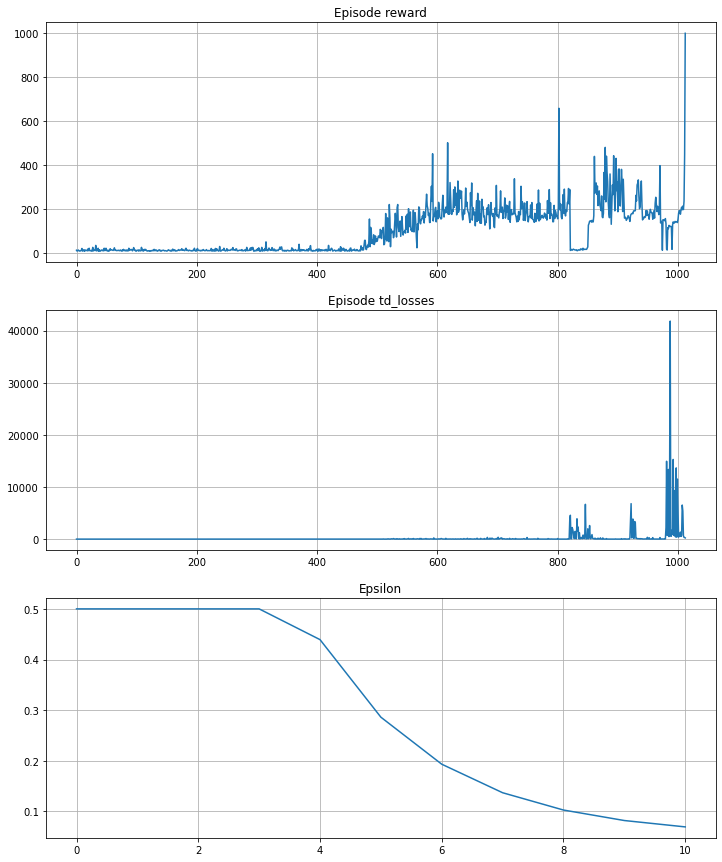

  1%|          | 10/1000 [03:11<5:16:10, 19.16s/it]


In [89]:
start_memory_length=5000
mini_sessions = 100
epochs=1000
batch_size=128

main_model = DQN_model()
target_model = DQN_model()
target_model.load_state_dict(main_model.state_dict())
optimizer = optim.Adam(main_model.parameters(),lr=1e-04,weight_decay=1e-08)

best_model = DQN_train(env,main_model,target_model,optimizer)

In [90]:
def play_DQN_agent(env,agent,eps):
    s = env.reset() 
    while True:    
        a = agent.get_action(s,eps)
        new_s, r, done, _ = env.step(a)
    
        s = new_s    
        if done:
            break

In [91]:
import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v1"), directory="videos", force=True) as env_monitor:
    play_DQN_agent(env_monitor,agent=best_model,eps=0)

In [92]:
from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

In [93]:
torch.save(best_model,'./DQN_cartpole.pth')